# DTLZ2 Benchmark
## Imports

In [3]:
from bofire.benchmarks.multi import DTLZ2
from bofire.benchmarks.benchmark import run
from bofire.utils.multiobjective import compute_hypervolume
from bofire.samplers import PolytopeSampler
from bofire.strategies.random import RandomStrategy
from bofire.domain.domain import Domain
from bofire.domain.features import OutputFeatures, ContinuousOutput, ContinuousInput, InputFeatures
from bofire.domain.objective import MaximizeObjective
from bofire.strategies.botorch.qehvi import BoTorchQehviStrategy
from functools import partial

ImportError: cannot import name 'MaximizeObjective' from 'bofire.domain.features' (c:\users\j33463\onedrive - evonik industries ag\sandbox\bofire\bofire\domain\features.py)

## Manual setup of the optimization domain

The following cell shows how to manually setup the optimization problem in BoFire for didactic purposes. In the following the implemented benchmark module is then used.

In [ ]:
input_features = InputFeatures(features=[ContinuousInput(key=f"x_{i}", lower_bound=0, upper_bound=1) for i in range(6)])
# here the minimize objective is used, if you want to maximize you have to use the maximize objective.
output_features = OutputFeatures(features=[ContinuousOutput(key=f"f_{i}", objective=MaximizeObjective(w=1.)) for i in range(2)])
# no constraints are present so we can create the domain
domain = Domain(input_features=input_features, output_features=output_features)

## Random Strategy

In [3]:
def sample(domain):
    sampler = PolytopeSampler(domain=domain)
    sampled = sampler.ask(10)
    return sampled

def hypervolume(domain: Domain) -> float:
    assert domain.experiments is not None
    return compute_hypervolume(
        domain, domain.experiments, ref_point={"f_0": 1.1, "f_1": 1.1}
    )

random_results = run(
    DTLZ2(dim=6),
    strategy_factory=RandomStrategy,
    n_iterations=50,
    metric=hypervolume,
    #initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.178: 100%|██████████| 50/50 [00:00<00:00, 121.06it/s]


## QEHVI Strategy
### Automatic run

In [4]:
results = run(
    DTLZ2(dim=6),
    strategy_factory=partial(BoTorchQehviStrategy, ref_point={"f_0": 1.1, "f_1": 1.1}),
    n_iterations=50,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.389: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


### Manual setup

#### Using the default Models

In [6]:
# we get the domain from the benchmark module, in real use case we have to build it on our own
# make sure that the objective is set correctly
domain = DTLZ2(dim=6).domain
# we generate training data
experiments = DTLZ2(dim=6).f(domain.inputs.sample(10), return_complete=True)
# we setup the strategy
# providing of a reference point is not mandatory but can help
# the reference point has to be wrt to the assigned objective always worse than the points on the paretofront.
recommender = BoTorchQehviStrategy(domain=domain, ref_point={"f_0": 1.1, "f_1": 1.1})
# we tell the strategy our historical data
recommender.tell(experiments=experiments)
# we ask for a new point to evaluate
candidates = recommender.ask(candidate_count=1)
# we show the candidate
display(candidates)
# this candidate has to be then provided to the benchmark function and evaluated and then told back to the optimizer to get the next candidate



,x_0,x_1,x_2,x_3,x_4,x_5,f_0_pred,f_0_sd,f_0_des,f_1_pred,f_1_sd,f_1_des
0,0.900817,0.942544,0.0,0.381987,0.43767,0.475749,0.823798,0.48822,-0.823798,0.86826,0.410369,-0.86826


#### Setup specific models

In [10]:
from bofire.models.gps import SingleTaskGPModel
from bofire.models.gps.kernels import RBFKernel, ScaleKernel
from bofire.models.torch_models import BotorchModels

# in this case you would use non default kernels for the different outputs
# it is also possible to build the models for a subset of the complete features
recommender = BoTorchQehviStrategy(domain=domain, ref_point={"f_0": 1.1, "f_1": 1.1}, 
    model_specs=BotorchModels(models=[
        SingleTaskGPModel(
            input_features=domain.inputs,
            output_features=OutputFeatures(features=[domain.outputs[0]]), 
            kernel=ScaleKernel(base_kernel=RBFKernel(ard=True))),
        SingleTaskGPModel(
            input_features=domain.inputs,
            output_features=OutputFeatures(features=[domain.outputs[1]]),
            kernel=ScaleKernel(base_kernel=RBFKernel(ard=False))),
    ]))
# we tell the strategy our historical data
recommender.tell(experiments=experiments)
# we ask for a new point to evaluate
candidates = recommender.ask(candidate_count=1)
# we show the candidate
display(candidates)


,x_0,x_1,x_2,x_3,x_4,x_5,f_0_pred,f_0_sd,f_0_des,f_1_pred,f_1_sd,f_1_des
0,0.821032,0.0,0.554648,1.0,1.0,1.0,0.156237,0.107044,-0.156237,0.811459,0.344258,-0.811459


## Performance Plot

Text(0, 0.5, 'f_1')

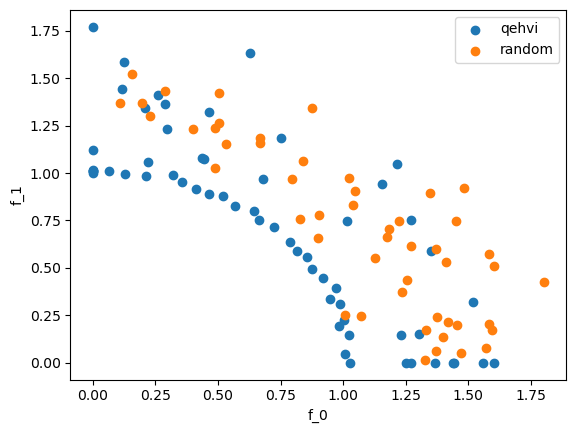

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(results[0][0].domain.experiments.f_0, results[0][0].domain.experiments.f_1, label = "qehvi")
ax.scatter(random_results[0][0].domain.experiments.f_0, random_results[0][0].domain.experiments.f_1, label = "random")

ax.legend()

ax.set_xlabel("f_0")
ax.set_ylabel("f_1")